# Erosion model for Chagos Rats

The models here will be run in [Python](https://www.python.org), using the [PyMC3 package](https://github.com/pymc-devs/pymc3).

### Data wrangling

The first step is to instantiate the various python packages needed for the analysis:

In [1]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap as bm
from scipy.stats import gaussian_kde
import scipy as sp
import pymc3 as pm
import theano.tensor as tt
import matplotlib as mp
import sqlite3
import os


# Return list of unique items and an index of their position in L
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Return list of unique items and an index of their position in long, relative to short
def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Path to plot storage
plotdir = os.getcwd()+'/plots'

/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import age and growth data
xdata = pd.read_csv('Chagos_function.csv')
xdata.head()

,Treatment,Atoll,Island,Transect,grazing_prop_reef,Erosion_t_ha,Structural_complexity,Coral_cover
0,No_rats,Great_Chagos_Bank,Middle_Brother,1,11.800741,155.013787,3.000000,6.330
1,No_rats,Great_Chagos_Bank,Middle_Brother,2,11.303339,121.614844,2.987179,40.330
2,No_rats,Great_Chagos_Bank,Middle_Brother,3,3.511624,62.013236,2.000000,23.692
3,No_rats,Great_Chagos_Bank,Middle_Brother,4,2.211482,34.852228,2.000000,32.000
4,No_rats,Great_Chagos_Bank,Nelson_Island,1,18.567027,154.658501,1.500000,12.670


In [3]:
# Response
grazing = np.round(xdata.grazing_prop_reef.values)
erosion = np.round(xdata.Erosion_t_ha.values)
lerosion = np.log(erosion+1)

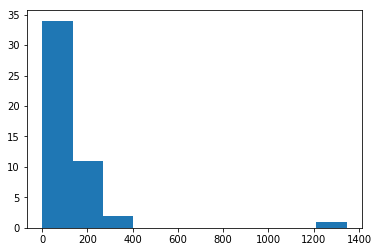

In [4]:
plt.hist(erosion);

In [5]:
# Covariates
complexity = xdata.Structural_complexity.values
hc = xdata.Coral_cover.values
rats = 1*(xdata.Treatment.values!='No_rats')

# Hierarchy
Island,Is = indexall(xdata.Island.values)
nisland = len(Island)

# Erosion model

In [6]:
Model = pm.Model()

with Model:
    
    # Global prior
    γ = pm.Normal('Average_grazing', mu=0.0, tau=0.001)
    # Inter-island variablity
    σγ = pm.Uniform('SD_reef', lower=0, upper=100)
    τγ = σγ**-2
    β0 = pm.Normal('Island_d15N', mu=γ, tau=τγ, shape=nisland)
    
    # Rat effect
    β1 = pm.Normal('Rat_effect', mu=0.0, tau=0.001)
    # Structural complexity
    β2 = pm.Normal('complexity', mu=0.0, tau=0.001)
    # Hard coral
    β3 = pm.Normal('hc', mu=0.0, tau=0.001)
    
    # Mean model
    μ = β0[Is]+β1*rats+β2*complexity+β3*hc

    λ = tt.exp(μ)

    # Likelihood
    Yi = pm.Poisson('Yi', λ, observed=erosion)

In [7]:
# Sampling
with Model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|█████████▉| 5496/5500 [01:20<00:00, 67.95it/s]/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.8876456072657631, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 5500/5500 [01:20<00:00, 67.96it/s]


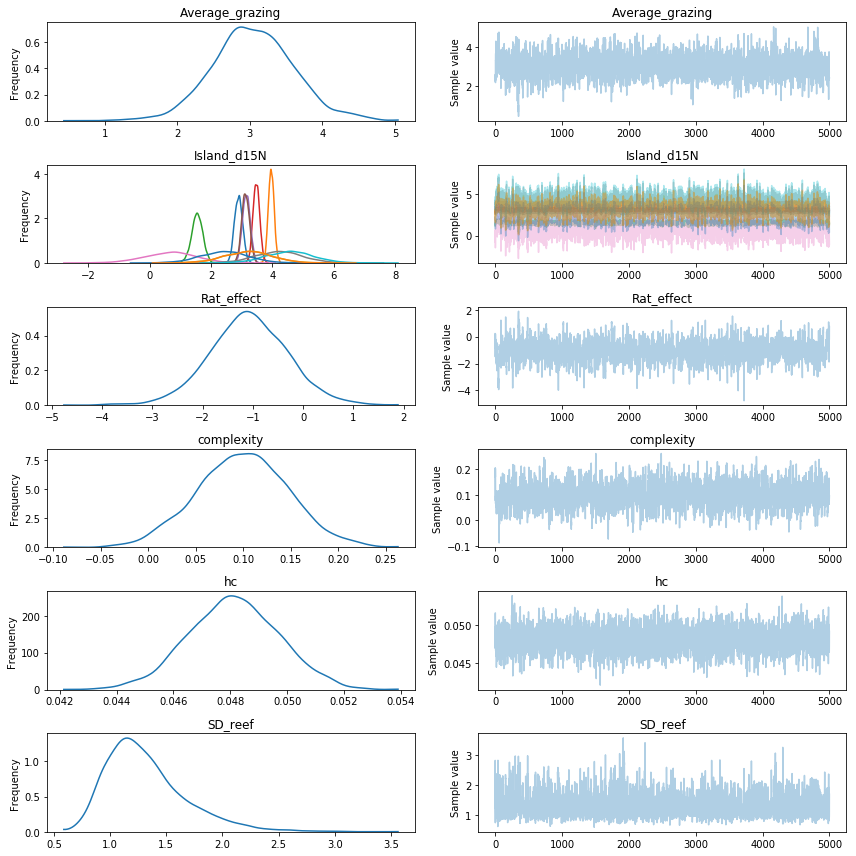

In [8]:
pm.traceplot(trace);

In [9]:
out = pm.backends.tracetab.trace_to_dataframe(trace)

In [10]:
out.head()

,Average_grazing,Island_d15N__0,Island_d15N__1,Island_d15N__2,Island_d15N__3,Island_d15N__4,Island_d15N__5,Island_d15N__6,Island_d15N__7,Island_d15N__8,Island_d15N__9,Island_d15N__10,Island_d15N__11,Rat_effect,complexity,hc,SD_reef
0,2.267741,2.877862,3.948971,1.549771,3.498073,3.118064,3.034899,-0.815355,2.860063,1.966997,3.286213,1.112696,1.845588,0.220418,0.079543,0.049759,1.240326
1,2.355812,2.565859,3.723789,1.303670,3.238069,2.844439,2.959637,0.033685,3.319161,2.365851,3.677219,1.671579,2.247316,-0.451775,0.206079,0.046986,2.812012
2,2.513392,2.611084,3.797112,1.156582,3.194854,2.748434,2.785315,0.657897,4.319763,3.217536,4.743506,2.339750,3.176911,-1.497189,0.193266,0.051638,0.882159
3,2.596383,2.599073,3.751369,1.177288,3.191134,2.776414,2.682295,0.731546,4.090785,3.191704,4.466573,2.319136,2.923627,-1.266732,0.170285,0.051634,0.741091
4,2.498712,2.678163,3.785519,1.490284,3.246980,2.845744,2.909173,-1.488156,2.543392,1.638827,3.051618,0.804850,1.542108,0.208298,0.204179,0.048731,2.139093


In [11]:
out.to_csv('erosion_results.csv')